In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

In [2]:
# Step 1: Download S&P 500 historical data
sp500 = yf.download('^GSPC', start='2020-01-01', end='2024-12-31')

# Step 2: Ensure datetime index
sp500.index = pd.to_datetime(sp500.index)
sp500 = sp500[['Close']].dropna()
print(sp500.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price             Close
Ticker            ^GSPC
Date                   
2020-01-02  3257.850098
2020-01-03  3234.850098
2020-01-06  3246.280029
2020-01-07  3237.179932
2020-01-08  3253.050049


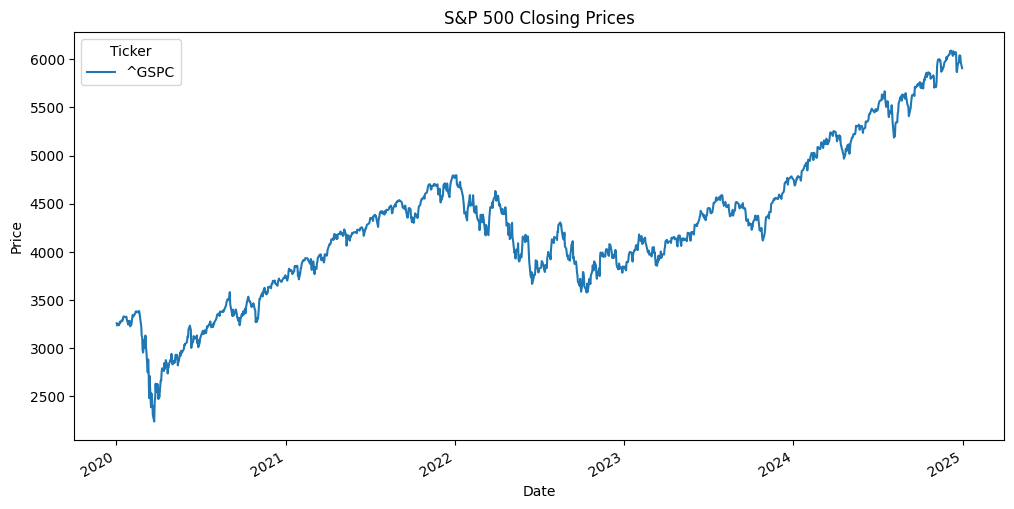

In [3]:
# Step 3: Plot the closing price
sp500['Close'].plot(figsize=(12, 6), title='S&P 500 Closing Prices')
plt.ylabel("Price")
plt.show()

In [4]:
# Step 4: ADF test for stationarity
result = adfuller(sp500['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Step 5: First differencing
sp500_diff = sp500['Close'].diff().dropna()

# Recheck stationarity
result = adfuller(sp500_diff)
print(f'p-value after differencing: {result[1]}')



ADF Statistic: -0.3038411840907277
p-value: 0.9249585409981842
p-value after differencing: 4.118883645115728e-20


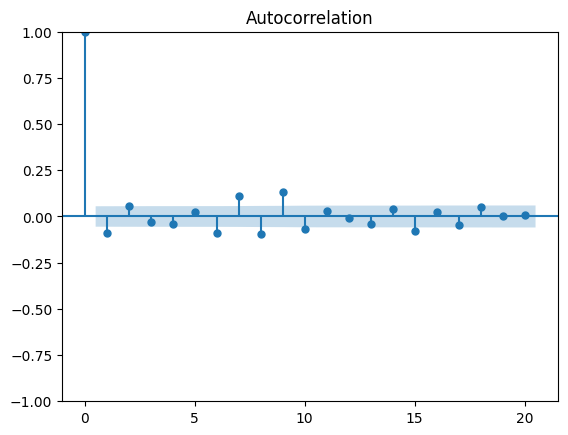

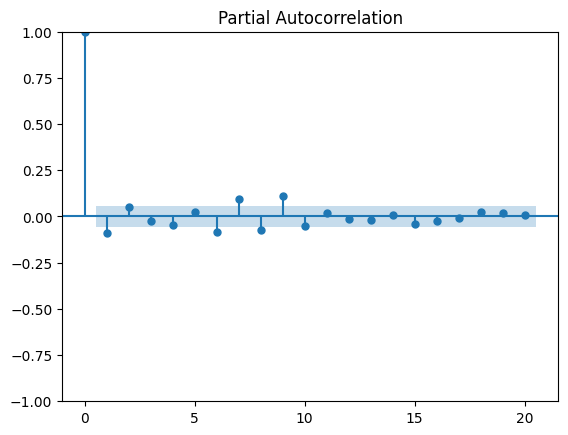

In [5]:
# Step 6: ACF and PACF plots
plot_acf(sp500_diff, lags=20)
plt.show()

plot_pacf(sp500_diff, lags=20)
plt.show()



In [6]:
# Step 7: Train-Test Split
train = sp500['Close'][:-30]
test = sp500['Close'][-30:]



In [7]:
# Step 8: Fit ARIMA model (Example: ARIMA(5,1,3))
model = ARIMA(train, order=(5, 1, 3))
model_fit = model.fit()
print(model_fit.summary())



D:\SP500\sp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\SP500\sp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\SP500\sp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\SP500\sp_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\SP500\sp_env\Lib\site-p

                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 1227
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -6476.388
Date:                Sun, 25 May 2025   AIC                          12970.777
Time:                        16:00:57   BIC                          13016.780
Sample:                             0   HQIC                         12988.088
                               - 1227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6779      0.081     -8.420      0.000      -0.836      -0.520
ar.L2          0.8806      0.040     21.878      0.000       0.802       0.959
ar.L3          0.7859      0.089      8.854      0.0

D:\SP500\sp_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
# Step 9: Forecast
forecast = model_fit.forecast(steps=30)
forecast.index = test.index  # Align forecast index with test data



D:\SP500\sp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\SP500\sp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [9]:
# Align test and forecast by index
test_aligned, forecast_aligned = test.align(forecast, join='inner', axis=0)

def to_1d_array(obj):
    if isinstance(obj, pd.DataFrame):
        # If DataFrame has only one column, get that column as 1D array
        if obj.shape[1] == 1:
            return obj.iloc[:, 0].values
        else:
            raise ValueError("Expected a single-column DataFrame")
    elif isinstance(obj, pd.Series):
        return obj.values
    else:
        # Already numpy array or something else
        return np.array(obj)

y_true = to_1d_array(test_aligned)
y_pred = to_1d_array(forecast_aligned)

# RMSE, MAE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

# MAPE (ignore zero actuals)
non_zero_mask = y_true != 0
mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# R2 score
r2 = r2_score(y_true, y_pred)

# Pearson correlation and p-value
pearson_corr, pearson_pval = pearsonr(y_true, y_pred)

# Directional Accuracy
actual_diff = test_aligned.diff().dropna()
forecast_diff = forecast_aligned.diff().dropna()

aligned_actual_diff, aligned_forecast_diff = actual_diff.align(forecast_diff, join='inner', axis=0)
sign_actual = np.sign(aligned_actual_diff.values)
sign_forecast = np.sign(aligned_forecast_diff.values)
directional_accuracy = np.mean(sign_actual == sign_forecast) * 100

# Print metrics
print(f"📉 ARIMA RMSE: {rmse:.2f}")
print(f"📉 ARIMA MAE: {mae:.2f}")
print(f"📉 ARIMA MAPE: {mape:.2f}%")
print(f"📊 ARIMA R2: {r2:.4f}")
print(f"📈 ARIMA Pearson Correlation: {pearson_corr:.4f} (p={pearson_pval:.4g})")
print(f"📉 ARIMA Directional Accuracy: {directional_accuracy:.2f}%")

📉 ARIMA RMSE: 73.38
📉 ARIMA MAE: 65.94
📉 ARIMA MAPE: 1.10%
📊 ARIMA R2: -0.0834
📈 ARIMA Pearson Correlation: 0.1563 (p=0.4096)
📉 ARIMA Directional Accuracy: 55.05%


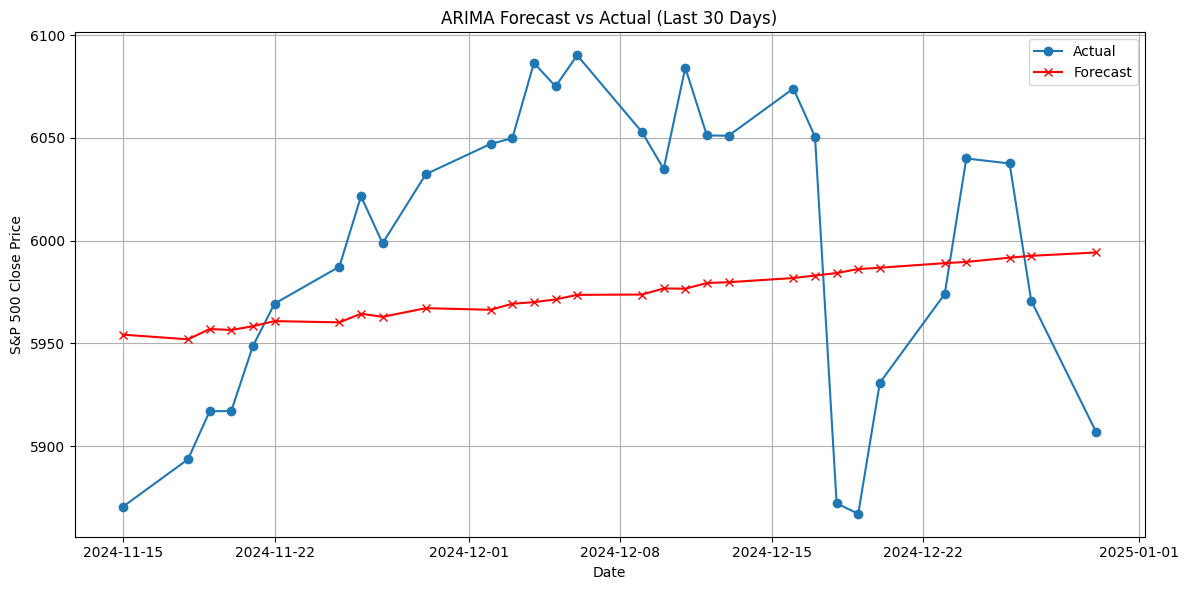

In [10]:
# Step 11: Plot forecast vs actual
plt.figure(figsize=(12, 6))
#plt.plot(train.index[-100:], train[-100:], label='Train')
plt.plot(test.index, test, label='Actual', marker='o')
plt.plot(forecast.index, forecast, label='Forecast', marker='x', color='red')
plt.title('ARIMA Forecast vs Actual (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()